# ***Outline:***
# ***1.Preprocessing***
# ***2.Model***

#.
#.***1.Preprocessing***
#.

# 引入需要的套件、觀看套件的版本

In [ ]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

!pip install tensorflow-gpu==2.4.1
clear_output()

import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.4.1


# 輸出的結果微調，以便觀察


In [ ]:
#避免 TensorFlow 吐給我們太多不必要的資訊
import logging
logging.basicConfig(level=logging.DEBUG)
np.set_printoptions(suppress=True)  
#讓numpy不要顯示科學記號，以便觀察輸出變化

# 路徑的相關設定

In [ ]:
output_dir = "nmt" #輸出資料夾
log_dir = os.path.join(output_dir, 'logs') #for TensorBoard 
download_dir = "tensorflow-datasets/downloads"  #下載資料夾

en_vocab_file = os.path.join(output_dir, "en_vocab") 
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")

# 想要查看特定的路徑是否存在，不分檔案或目錄
# 沒有存在，就創建一個
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# os.makedirs(path,mode) 方法用於遞歸"創建"目錄
# 1.path --需要遞歸創建的目錄，可以是相對或者絕對路徑 
# 2.mode --權限模式

# 選擇數據集，查看內容物

In [ ]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")  #tfds = tensorflow_datasets
pprint(tmp_builder.subsets)  #看tmp_builder裡面含有什麼子集合　

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: wmt19_translate/zh-en/1.0.0
INFO:absl:Load dataset info from /tmp/tmpjlmffvr3tfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Skipping sub-dataset that does not include language pair: europarl_v9
INFO:absl:Skipping sub-dataset that does not include language pair: europarl_v7_frde
INFO:absl:Skipping sub-dataset that does not include language pair: paracrawl_v3
INFO:absl:Skipping sub-dataset that does not include language pair: paracrawl_v1_ru
INFO:absl:Skipping sub-dataset that does not include language pair: paracrawl_v3_frde
INFO:absl:Skipping sub-da

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


# 正式載讀我要的資料集

In [ ]:
# 指定"新聞評論這個資料來源 
# 先建立config(配置)
# 供下一步驟tfds.builder的超參數使用

config = tfds.translate.wmt.WmtConfig(
  version='0.0.3', 
  #experiments={tfds.core.Experiment.S3: False},
  language_pair=("zh", "en"),
  subsets={tfds.Split.TRAIN: ["newscommentary_v14"]}
)

#載讀data步驟一.按名稱獲取: 選tfds裏頭的wmt_translate去做相關的設定
#此時，builder已為tf.datasets的資料 
builder = tfds.builder("wmt_translate", config=config)  

#載讀data步驟二.產生資料
builder.download_and_prepare(download_dir=download_dir)
clear_output()

#小節核心人物:config　-> builder -> download_dir(上面定義完了)

# 分割資料集:訓練、驗證、剩下丟棄


In [ ]:
examples_tra = builder.as_dataset(split= 'train[:20%]' , as_supervised=True, shuffle_files=True)
train_examples = examples_tra
print(train_examples)

examples_val = builder.as_dataset(split= 'train[21%:22%]' , as_supervised=True, shuffle_files=True)
val_examples = examples_val
print(val_examples)

INFO:absl:Constructing tf.data.Dataset for split train[:20%], from /root/tensorflow_datasets/wmt_translate/zh-en/0.0.3
INFO:absl:Constructing tf.data.Dataset for split train[21%:22%], from /root/tensorflow_datasets/wmt_translate/zh-en/0.0.3


<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>
<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>



# 核心人物:train_examples

# 建立中、英字典

In [ ]:
# 總結剛剛核心人物：subword_encoder_en (english版的encoder )


try:
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13 
      )
      #target_vocab_size:有需要可以調整字典大小 

  subword_encoder_en.save_to_file(en_vocab_file) #將＂字典檔案存下＂以方便下次warmstart



print(f"字典大小：{subword_encoder_en.vocab_size}")  
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()




載入已建立的字典： nmt/en_vocab
字典大小：8113
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']



In [ ]:
%%time
try:
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) #*****每一個中文字就是字典裡的一個單位(一個漢字可以代表的東西很多)
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

載入已建立的字典： nmt/zh_vocab
字典大小：4205
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 105 ms, sys: 13.1 ms, total: 118 ms
Wall time: 119 ms


In [ ]:
# subword_encoder_en、subword_encoder_zh

def encode(en_t, zh_t):
  # 字典的索引從 0 開始
  
  # subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 而 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  
  
  # 中文字典是依樣的方式
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  
  return en_indices, zh_indices

In [1]:
'''
train_dataset = train_examples.map(encode)
#這樣會報錯
'''

'\ntrain_dataset = train_examples.map(encode)\n#這樣會報錯\n'

#這是因為目前 tf.data.Dataset.map 函式裡頭的計算是在計算圖模式（Graph mode）下執行，所以裡頭的 Tensors 並不會有 Eager Execution 下才有的 numpy 屬性。
#.
#解法是使用tf.py_function將我們剛剛定義的 encode 函式
#把它包成一個以eager模式的encode執行的 TensorFlow Operation

In [ ]:
def tf_encode(en_t, zh_t):
  # 要通過 `tf.py_funtion` 裡頭才是 Eager Tensors
  # 因為索引都是整數，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

#***先來測試
#***先來測試
#***先來測試



In [ ]:
tmp_dataset = train_examples.map(tf_encode)
# indices:index的複數
en_indices,zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)
tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


In [ ]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

# 每個例子裡的索引序列長度不一，這在建立 batch 時可能會發生問題。不過別擔心，輪到 padded_batch

In [ ]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 [8113   44   40 ...    0    0    0]
 ...
 [8113  122  506 ...    0    0    0]
 [8113   16  215 ...    0    0    0]
 [8113 7443 7889 ...    0    0    0]], shape=(64, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 [4205    5   10 ...    0    0    0]
 ...
 [4205   34    6 ...    0    0    0]
 [4205  317  256 ...    0    0    0]
 [4205  167  326 ...    0    0    0]], shape=(64, 40), dtype=int64)


#***再來正式
#***再來正式
#***再來正式

In [ ]:

train_dataset = train_examples.map(tf_encode)


# 已包成以eager模式的encode執行的 TensorFlow Operation

In [ ]:
def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
              tf.size(zh) <= max_length)

In [ ]:
MAX_LENGTH = 40
BATCH_SIZE = 128    #一次回傳大小為 128 的 2 個 batch:（分別包含 128 個英文、中文的索引序列）
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保"隨機性"
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                  padded_shapes=([-1], [-1])) 
                  .prefetch(tf.data.experimental.AUTOTUNE)) # 加速用

# 驗證集(跟訓練集作法差不多)
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                padded_shapes=([-1], [-1])))

In [ ]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

# en_batch, zh_batch

英文索引序列的 batch
tf.Tensor(
[[8113 3372  934 ...    0    0    0]
 [8113 5619 7330 ...    0    0    0]
 [8113 2385  132 ...    0    0    0]
 ...
 [8113 3463    1 ...    0    0    0]
 [8113  122   21 ...    0    0    0]
 [8113 6104 2422 ...    0    0    0]], shape=(128, 40), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   59  101 ...    0    0    0]
 [4205  131   12 ...    0    0    0]
 [4205   44   87 ...    0    0    0]
 ...
 [4205  297  156 ...    3 4206    0]
 [4205  340  618 ...    3 4206    0]
 [4205   72  271 ...    0    0    0]], shape=(128, 40), dtype=int64)


#.
#.***2.Model***
#.

In [ ]:
def create_padding_mask(seq):
  # padding mask 的工作就是***把索引序列中為 0 的位置設為 1***
  mask = tf.cast(tf.equal(seq, 0), tf.float32) #判斷是否索引=0
  return mask[:, tf.newaxis, tf.newaxis, :] 
  #　(待讀更細)broadcasting:******多增加2維tf.newaxis、tf.newaxis******

In [ ]:
#打鐵趁熱，趕快進入下一個mask
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  # tf.linalg.band_part (****待待待待待待待待)
  return mask  # (seq_len, seq_len)

In [ ]:

# 為 Transformer 
# 準備 Encoder / Decoder 的遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) #看seq的長度
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

  # 將 `q`、 `k` 做**點積** 再 **scale**
  matmul_qk = tf.matmul(q, k, transpose_b=True)# (..., seq_len_q, seq_len_k)
  # 取得seq_k的序列長度，用[-1]，已經很熟悉了
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  # scale by sqrt(dk)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  

  # 將遮罩「加」到被丟入softmax前的 logits，這樣softmax完會 = 0
  if mask is not None:
    scaled_attention_logits += (mask * -1e9) 
    # -1e9 相當於 -1 * 10**9   

  # 取 softmax 是為了得到總和為 1 的比例
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
  # (..., seq_len_q, seq_len_k)

  # 以注意權重對 v 做加權平均（weighted average）[應該加權總合]
  output = tf.matmul(attention_weights, v)  
  # (..., seq_len_q, depth_v)
  
  return output, attention_weights

'''
matmul_qk = tf.matmul(q, k, transpose_b=True)
dk = tf.cast(tf.shape(k)[-1], tf.float32)
'''

'\nmatmul_qk = tf.matmul(q, k, transpose_b=True)\ndk = tf.cast(tf.shape(k)[-1], tf.float32)\n'

In [ ]:
# 因為待會是要套詞嵌入張量，所以肯定會有d_model
# num_heads:我要幾頭的需求


def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]  
  
  assert d_model % num_heads == 0 #*****assert:確保這個depth是整數的
  depth = d_model // num_heads  #分成多頭以後，每個向量的維度 
  # depth就是說，每個頭的深度 
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  
  # 最後一個維度:從4個維度 變成 2個維度，
  # 張量 x 從 三 維到 四 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))

  # x -> reshaped_x
  #(batch_size, seq_len, d_model)->(batch_size, seq_len, num_heads, depth) 
  # 以(2,8,4)為例:(2,8,4) -> (2,8,2,2) 

  # (2,8,2,2) -> (2,2,8,2) [(batch_size, num_heads, seq_len, depth)]
  # perm:欲重新編排的index順序
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3]) #(2,2,8,2)
  
  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候"建立一些必要參數"
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # *****幾個 heads
    self.d_model = d_model # *****在split_heads之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    self.depth = d_model // self.num_heads  # *****每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換(參數矩陣)
    self.wk = tf.keras.layers.Dense(d_model)  # 這邊沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多heads串接後，最後再通過一次線性轉換
  

  # 前面定義的split_heads
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  # multi-head attention 的實際執行流程，# 參數順序
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度，分成，num_heads 個 depth 維度的 小qi ki vi
    # ****拆解完****
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 
    #　讓每個句子的每個 head 的 qi, ki, vi 
    # 都各自進行注意力機制
    # (會輸出多一個 head 維度)
    # *****recall:剛剛split_heads最後輸出的shape: (batch_size, num_heads, seq_len, depth)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    # scaled_attention.shape(注意權重對 v 做加權平均) == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape() == (batch_size, num_heads, seq_len_q, seq_len_k)

    # ***再串接回去***
    # 跟我們在 `split_heads` 函式做的事情剛好相反
    # 先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape( scaled_attention,(batch_size, -1, self.d_model) ) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  
    # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
# Transformer裡的Encoder/Decoder layer 
# 都有使用到的 Feed Forward 

def point_wise_feed_forward_network(d_model, dff):
  
  # *****dff : FFN中間層的維度
  # *****讓 dff 大於 d_model，
  # (讓 FFN 從輸入的 d_model 維度裡頭擷取些有用的資訊)
  # 此FFN(全聯通)，對輸入dff，做兩個線性轉換（中間加了一個ReLU activation func）
  
  
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'), #(batch_size,seq_len,dff)
      tf.keras.layers.Dense(d_model)  #(batch_size,seq_len,d_model)
  ])

# 本cell核心人物 : 回傳一個新的 tf.keras.Sequential 模型


# Encoder 裡頭會有 N 個 EncoderLayers，
# 而每個 EncoderLayer 裡
# 又有兩個 sub-layers: MHA & FFN

In [ ]:


class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)  #前面定義的
    self.ffn = point_wise_feed_forward_network(d_model, dff) #前面定義的

    # layer norm 常在 RNN-based 的模型被使用。
    # 一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)   

    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)  


  def call(self, x, training, mask):
    # attn = attention_weights
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    # 其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)

    # sub-layer 1: MHA
    # ******recall : MHA 的 return為 output, attention_weights
    # Encoder＂利用注意機制＂關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外還要 padding mask 遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  

    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)#記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2



#.
#.
#.
#*****需要丟入`training`參數是因為
#(dropout 在訓練以及測試的行為有所不同)

#.

#則每個 sub-layer 的處理邏輯如下：
#sub_layer_out = Sublayer(x)
#sub_layer_out = Dropout(sub_layer_out)
#out = LayerNorm(x + sub_layer_out)

#.
#.
#.



# Decoder 裡頭會有 N 個 DecoderLayer，
# 而
# DecoderLayer 又有三個 sub-layers: 
# 1.自注意的 MHA, 
# 2.關注 Encoder 輸出的 MHA 
# 3.FFN

In [ ]:


class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    


    # 所有sub-layers [指的是self.mha1、self.mha2、self.ffn] 
    # 的主要輸出，皆為(batch_size, target_seq_len, d_model)

    # enc_output 
    # 為 Encoder 輸出序列，
    # shape 為 (batch_size, input_seq_len, d_model)

    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)
    # sub-layer1->sub-layer2->sub-layer3

  def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
    # sub-layer 1: ＂Decoder layer自己＂　對輸出序列做注意力。
    # 我們＂同時＂需要 １．look ahead mask 及　２．輸出序列的 padding mask 
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 ＂Encoder的最後輸出＂
    # 記得我們一樣需要對 Encoder 的輸出套用１．padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, inp_padding_mask)  
    # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  
    # (batch_size, target_seq_len, d_model)

    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  
    # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  
    # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2
    # *****本cell的核心人物      
    # 輸出1. `out3` 以外
    # 輸出2. ＂Decoder layer自己＂對輸出序列 的注意力權重
    # 輸出3. Decoder layer 關注＂Encoder的最後輸出＂ 的注意力權重
    # 方便之後理解模型內部狀況

In [ ]:
# 以下直接參考 TensorFlow 官方 tutorial 

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)



# Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)  
    
    return x 

# Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

# Transformer

In [ ]:
# Transformer 之上已經沒有其他 layers 了
# 使用 tf.keras.Model 建立一個模型

class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  #　input_vocab_size、target_vocab_size(輸入跟目標輸出的字典大小)
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # *****enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 1 用，
  # 一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):


    #(待)enc_output.shape ==  (batch_size, inp_seq_len, d_model)
    enc_output = self.encoder(inp, training, enc_padding_mask)  
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # 這次的 mask 將序列中***不等於 0 的位置視為 1***
  # 其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)

  loss_ *= mask  # ****重要:只計算非<pad>位置的損失 
  
  return tf.reduce_mean(loss_)


train_loss   = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
# 論文原始設定
# num_layers=6
# d_model=512
# dff=2048

num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8115
target_vocab_size: 4207


In [ ]:

# *****客製化 learning rate schdeule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps  # epochs數之分水嶺 
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt.參數跟論文一樣
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

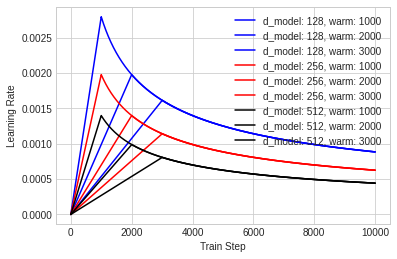

In [ ]:
# 用list來分別測試不同的d_models
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)] #[1000,2000,3000]

schedules = []
labels = []
colors = ["blue", "red", "black"]

for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])
plt.legend()
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
              input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers

d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")


這個 Transformer 有 4 層 Encoder / Decoder layers

d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8115
target_vocab_size: 4207
dropout_rate: 0.1




In [ ]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec
'''
split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split
'''

'\nsplit = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])\nsplit\n'

In [ ]:
# 方便比較不同實驗/不同超參數設定的結果(?
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

已讀取最新的 checkpoint，模型已訓練 30 epochs。


In [ ]:
# 為 Transformer 
# 準備 Encoder / Decoder 的遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
@tf.function  # decorate :讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 丟入 `tar_inp` 而非 `tar`。將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, True,enc_padding_mask,combined_mask,dec_padding_mask)
    # 計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 可記錄到*****TensorBoard
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
# 定義我們要看幾遍數據集，(待) -EPOCHS的 "-" 應該可以拿掉

EPOCHS = 100
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS  )}") 
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()  
  train_loss.reset_states()  
  train_accuracy.reset_states()
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  
  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1) 
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1) 
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 30 epochs。
剩餘 epochs：-70
Saving checkpoint for epoch 31 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-31
Epoch 31 Loss 1.1133 Accuracy 0.4175
Time taken for 1 epoch: 88.22058176994324 secs

Saving checkpoint for epoch 32 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-32
Epoch 32 Loss 1.0891 Accuracy 0.4215
Time taken for 1 epoch: 20.994211673736572 secs

Saving checkpoint for epoch 33 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-33
Epoch 33 Loss 1.0695 Accuracy 0.4241
Time taken for 1 epoch: 16.852424383163452 secs

Saving checkpoint for epoch 34 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-34
Epoch 34 Loss 1.0475 Accuracy 0.4277
Time taken for 1 epoch: 21.03524422645569 secs

Saving checkpoint for epoch 35 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-35
Epoch 35 Loss 1.0306 Accuracy 0.4304
Time taken for 1 epoch: 21.88654637336731 secs

Saving checkpoint for epoch 36 at

In [ ]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
  # 準備英文句子前後會加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
  # 並在前後加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
  # 是一個只包含一個中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
  # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
  for i in range(MAX_LENGTH):
    # 每多一個生成的字就得產生新的遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                output,
                                False,
                                enc_padding_mask,
                                combined_mask,
                                dec_padding_mask)
    

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
    # 下個中文字的時候關注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的維度去掉後回傳預測的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
# 要被翻譯的英文句子
sentence = "The recent epidemic has severely affected the economies of various countries."

# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: The recent epidemic has severely affected the economies of various countries.
--------------------
predicted_seq: tf.Tensor(
[4205   72  271    1 1038  233  189   40   14  313    4  313    4  313
    4    1   22   49  120    1  292  304    3], shape=(23,), dtype=int32)
--------------------
predicted_sentence: 最近的疫情受到了各国各国各国的经济体的影响。


In [ ]:
predicted_seq, attention_weights = evaluate(sentence)
# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"
print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: The recent epidemic has severely affected the economies of various countries.
--------------------
predicted_seq: tf.Tensor(
[4205   72  271    1 1038  233  189   40   14  313    4  313    4  313
    4    1   22   49  120    1  292  304    3], shape=(23,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 23, 23)
decoder_layer1_block2.shape: (1, 8, 23, 17)
decoder_layer2_block1.shape: (1, 8, 23, 23)
decoder_layer2_block2.shape: (1, 8, 23, 17)
decoder_layer3_block1.shape: (1, 8, 23, 23)
decoder_layer3_block2.shape: (1, 8, 23, 17)
decoder_layer4_block1.shape: (1, 8, 23, 23)
decoder_layer4_block2.shape: (1, 8, 23, 17)
--------------------
layer_name: decoder_layer4_block2


In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

# 自定義字體變數
zhfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

# !!!!後續在相關函式中增加fontproperties=myfont屬性即可!!!!

--2021-06-19 18:27:42--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.2.113, 142.251.2.102, 142.251.2.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qvo40mlgit2unnuv349efmoo6rhjt5t3/1624127250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-06-19 18:27:43--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qvo40mlgit2unnuv349efmoo6rhjt5t3/1624127250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.251.2.1

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was alr

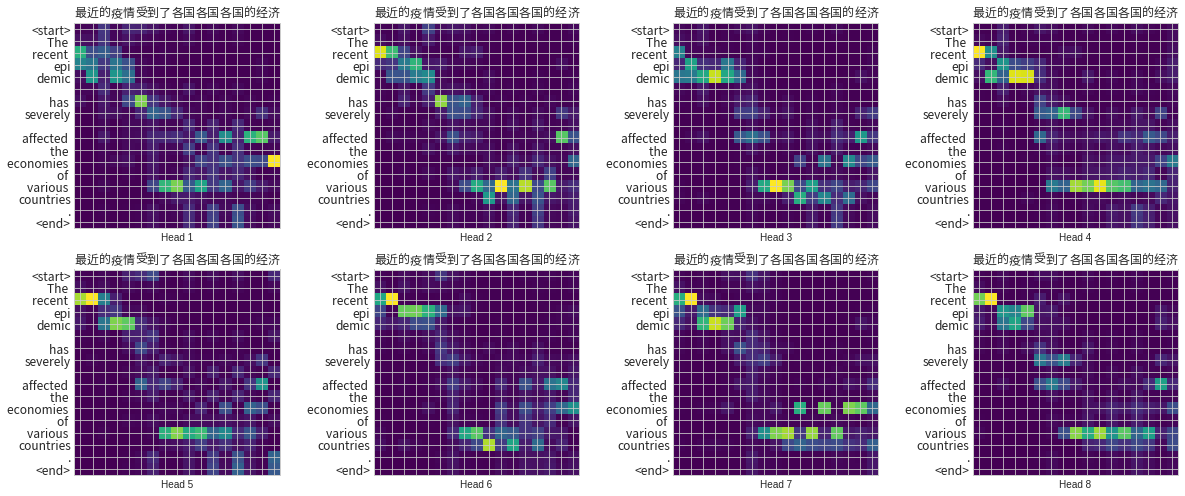

In [ ]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
#zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/SimHei/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  sentence = subword_encoder_en.encode(sentence)
  
  # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 將每個 head 的注意權重畫出
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)




plot_attention_weights(attention_weights,sentence,predicted_seq, layer_name, max_len_tar=18)

# The End